In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
import numpy as np
from defs import ArgoverseDataset
from defs import my_collate

In [2]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()

# Train Model

In [3]:
from tqdm import tqdm_notebook as tqdm

def train(model, train_loader, device, optimizer, epoch, log_interval=10000):
    model.train()
    criterion = nn.MSELoss()
    iterator = tqdm(train_loader, total=int(len(train_loader)))
    counter = 0
    # for i_batch, sample_batch in enumerate(train_loader):
    for batch_idx, (inp, out) in enumerate(iterator):
         
        # inp, out = sample_batch
        inp = inp.to(device)
        out = out.to(device)
        
        optimizer.zero_grad()
        
        inp = inp.reshape(inp.shape[0], inp.shape[3] * inp.shape[1] * inp.shape[2])
        pred_out = model(inp)

        pred_out = pred_out.reshape(out.shape[0], out.shape[1], out.shape[2], out.shape[3])
        out = out.reshape(out.shape[0], out.shape[1], out.shape[2], out.shape[3])
        
        loss = torch.sqrt(criterion(pred_out, out))
        
        l1_lambda = 0.0001
        l2_lambda = 1e-4
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())

        loss = loss + l1_lambda*l1_norm + l2_lambda*l2_norm
        
        
        loss.backward()
        optimizer.step()
        
        counter += 1
        iterator.set_postfix(loss=(loss.item()*inp.size(0) / (counter * train_loader.batch_size)))
        
    return (loss.item()*inp.size(0) / (counter * train_loader.batch_size))

In [4]:
def test(model, test_loader, device):
    model.eval()
    test_loss = 0
    correct = 0
    criterion = nn.MSELoss()
    with torch.no_grad():
        for i_batch, sample_batch in enumerate(test_loader):
            inp, out = sample_batch
            inp = inp.to(device)
            out = out.to(device)
            
            inp = inp.reshape(inp.shape[0], inp.shape[3] * inp.shape[1] * inp.shape[2])
            pred_out = model(inp)
            
            pred_out = pred_out.reshape(out.shape[0], out.shape[1], out.shape[2], out.shape[3])
            out = out.reshape(out.shape[0], out.shape[1], out.shape[2], out.shape[3])
            
        l1_lambda = 0.0001
        l2_lambda = 1e-4
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            
        test_loss += torch.sqrt(criterion(pred_out, out)).item() + l1_lambda*l1_norm + l2_lambda*l2_norm
            
    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))
    return test_loss

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        
        self.model = torch.nn.Sequential(
            torch.nn.Linear(19*60*4, 60*30*2),
            torch.nn.RReLU(lower=0.05, upper=0.5, inplace=False)
        )
        
    def forward(self, x):
        
        x = self.model(x)
        return x

In [6]:
if __name__ == '__main__':
    """Change to the data folder"""
    train_path = "./new_train/new_train"
    test_path = "./new_val_in/new_val_in"
    # number of sequences in each dataset
    # train:205942  val:3200 test: 36272 
    # sequences sampled at 10HZ rate
    
    # intialize a dataset
    val_dataset  = ArgoverseDataset(data_path=train_path)
    test_dataset = ArgoverseDataset(data_path=test_path)

    TRAIN_SET, TEST_SET = torch.utils.data.random_split(val_dataset, [169670, 36272])

    batch_size_train = 64
    batch_size_test = 2048


    train_loader = DataLoader(TRAIN_SET,batch_size=batch_size_train, shuffle = True, collate_fn=my_collate, num_workers=4,pin_memory=True)
    test_loader = DataLoader(TEST_SET,batch_size=batch_size_test, shuffle = True, collate_fn=my_collate, num_workers=4, pin_memory=True)


    learning_rate = 0.001
    # momentum = 0.2
    device = "cuda"
    model = MLP().to(device) #using cpu here
    torch.backends.cudnn.benchmark = True
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, 
                                betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    num_epoch = 35
    
    best_valid_loss = float('inf')
    
    valid_losses = []

    for epoch in range(1, num_epoch + 1):
        print("Epoch: " + str(epoch))
        train(model, train_loader, device, optimizer, epoch)
        valid_loss = test(model, test_loader, device)
        valid_losses.append(valid_loss)
        
        if epoch == 5:
            for g in optimizer.param_groups:
                g['lr'] = 0.00005
                
        if epoch == 15:
            for g in optimizer.param_groups:
                g['lr'] = 0.00001

        if epoch == 25:
            for g in optimizer.param_groups:
                g['lr'] = 0.000005
                
        if valid_loss <= best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'MLP-model.pt')

Epoch: 1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  




Test set: Average loss: 67.2099

Epoch: 2




Test set: Average loss: 74.0807

Epoch: 3




Test set: Average loss: 94.2746

Epoch: 4




Test set: Average loss: 82.3832

Epoch: 5




Test set: Average loss: 76.7144

Epoch: 6




Test set: Average loss: 14.4225

Epoch: 7




Test set: Average loss: 5.0596

Epoch: 8




Test set: Average loss: 5.5041

Epoch: 9




Test set: Average loss: 4.5870

Epoch: 10




Test set: Average loss: 4.2926

Epoch: 11




Test set: Average loss: 6.7699

Epoch: 12




Test set: Average loss: 4.9259

Epoch: 13




Test set: Average loss: 4.0344

Epoch: 14




Test set: Average loss: 4.1432

Epoch: 15




Test set: Average loss: 5.0076

Epoch: 16




Test set: Average loss: 1.9964

Epoch: 17




Test set: Average loss: 2.1348

Epoch: 18




Test set: Average loss: 2.1793

Epoch: 19




Test set: Average loss: 1.9211

Epoch: 20




Test set: Average loss: 2.0363

Epoch: 21




Test set: Average loss: 2.0483

Epoch: 22




Test set: Average loss: 2.0861

Epoch: 23




Test set: Average loss: 2.0291

Epoch: 24




Test set: Average loss: 2.1725

Epoch: 25




Test set: Average loss: 2.0942

Epoch: 26




Test set: Average loss: 1.8296

Epoch: 27




Test set: Average loss: 1.7873

Epoch: 28




Test set: Average loss: 1.7385

Epoch: 29




Test set: Average loss: 1.9643

Epoch: 30




Test set: Average loss: 1.7968

Epoch: 31




Test set: Average loss: 1.7637

Epoch: 32




Test set: Average loss: 1.7190

Epoch: 33




Test set: Average loss: 1.8131

Epoch: 34




Test set: Average loss: 1.7084

Epoch: 35




Test set: Average loss: 4.1608



In [7]:
best_valid_loss.item()

1.7084405422210693

In [8]:
num_epoch = 70
for epoch in range(36, num_epoch + 1):
    
    if epoch == 36:
        for g in optimizer.param_groups:
            g['lr'] = 0.00001
    
    print("Epoch: " + str(epoch))
    train(model, train_loader, device, optimizer, epoch)
    valid_loss = test(model, test_loader, device)
    valid_losses.append(valid_loss)
        
    if epoch == 46:
        for g in optimizer.param_groups:
            g['lr'] = 0.000001
                
    if epoch == 56:
        for g in optimizer.param_groups:
            g['lr'] = 0.0000001

    if epoch == 66:
        for g in optimizer.param_groups:
            g['lr'] = 0.00000005

            
    if valid_loss <= best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'MLP-model.pt')

Epoch: 36


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  




Test set: Average loss: 2.0355

Epoch: 37




Test set: Average loss: 1.9273

Epoch: 38




Test set: Average loss: 1.9866

Epoch: 39




Test set: Average loss: 2.0984

Epoch: 40




Test set: Average loss: 2.1722

Epoch: 41




Test set: Average loss: 1.8639

Epoch: 42




Test set: Average loss: 2.0270

Epoch: 43




Test set: Average loss: 2.1131

Epoch: 44




Test set: Average loss: 2.0306

Epoch: 45




Test set: Average loss: 2.0535

Epoch: 46




Test set: Average loss: 1.9379

Epoch: 47




Test set: Average loss: 1.5805

Epoch: 48




Test set: Average loss: 1.6766

Epoch: 49




Test set: Average loss: 1.6284

Epoch: 50




Test set: Average loss: 1.5507

Epoch: 51




Test set: Average loss: 1.6154

Epoch: 52




Test set: Average loss: 3.8255

Epoch: 53




Test set: Average loss: 1.6007

Epoch: 54




Test set: Average loss: 1.5851

Epoch: 55




Test set: Average loss: 1.5535

Epoch: 56




Test set: Average loss: 1.5963

Epoch: 57




Test set: Average loss: 3.8159

Epoch: 58




Test set: Average loss: 1.6108

Epoch: 59




Test set: Average loss: 3.7943

Epoch: 60




Test set: Average loss: 1.5519

Epoch: 61




Test set: Average loss: 1.5580

Epoch: 62




Test set: Average loss: 1.5952

Epoch: 63




Test set: Average loss: 1.5540

Epoch: 64




Test set: Average loss: 1.5619

Epoch: 65




Test set: Average loss: 1.5281

Epoch: 66




Test set: Average loss: 1.5540

Epoch: 67




Test set: Average loss: 3.7971

Epoch: 68




Test set: Average loss: 1.5580

Epoch: 69




Test set: Average loss: 1.5501

Epoch: 70




Test set: Average loss: 1.6040



In [9]:
best_valid_loss.item()

1.5281386375427246

# Plot Loss

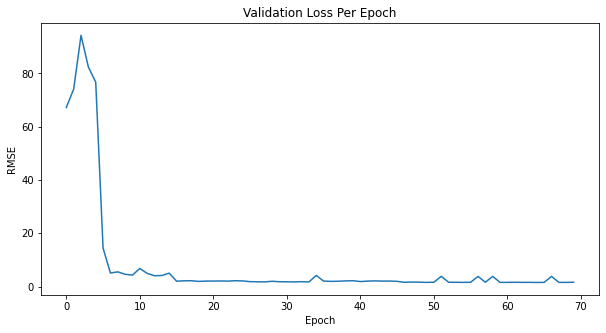

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.title("Validation Loss Per Epoch")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.plot(valid_losses)
plt.show()

# Training Samples

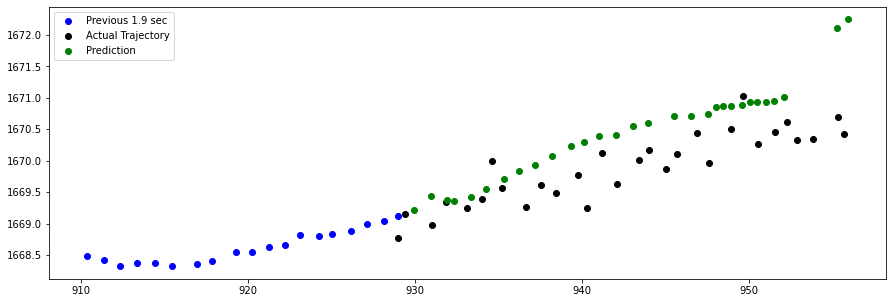

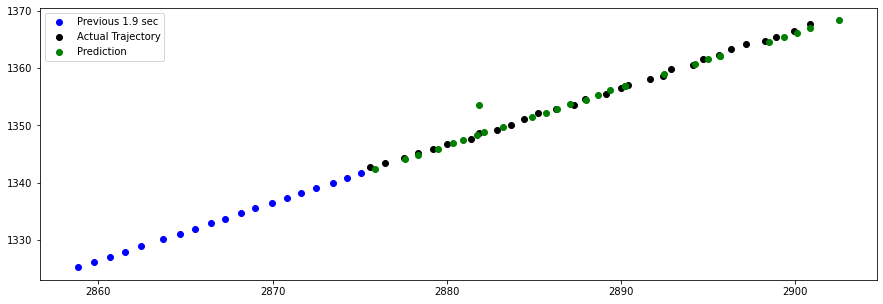

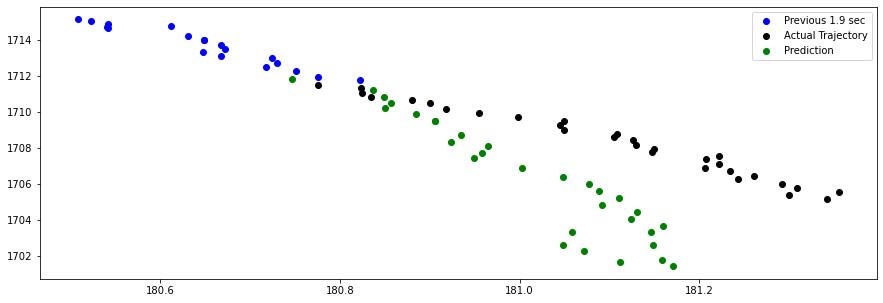

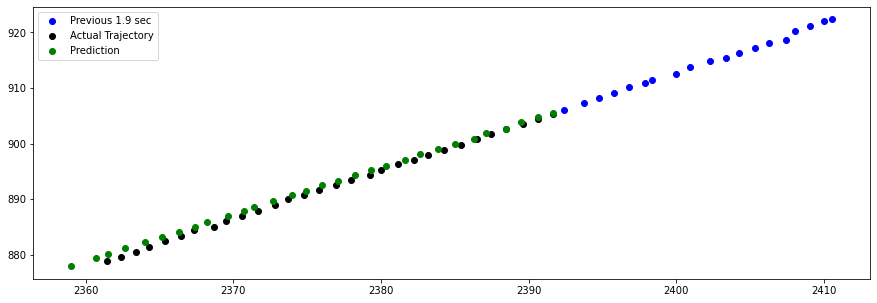

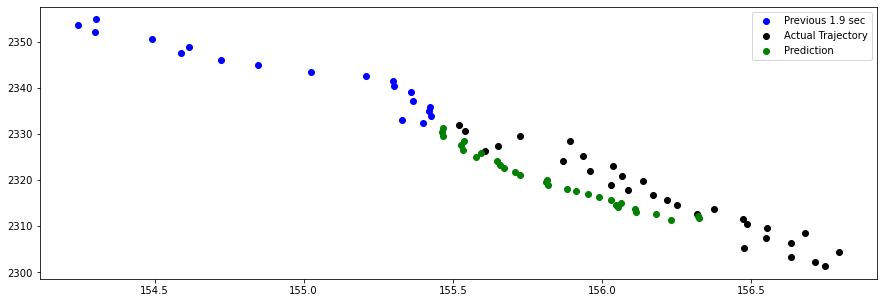

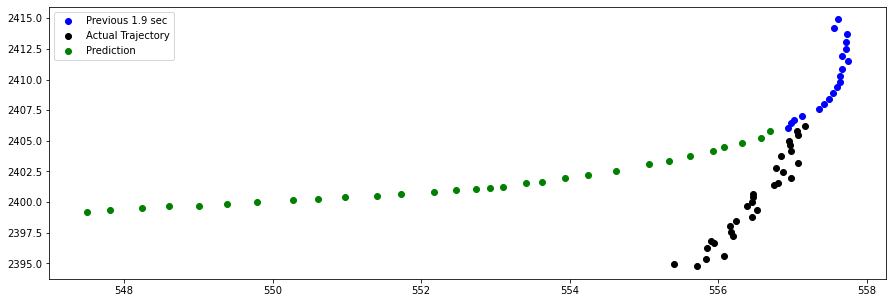

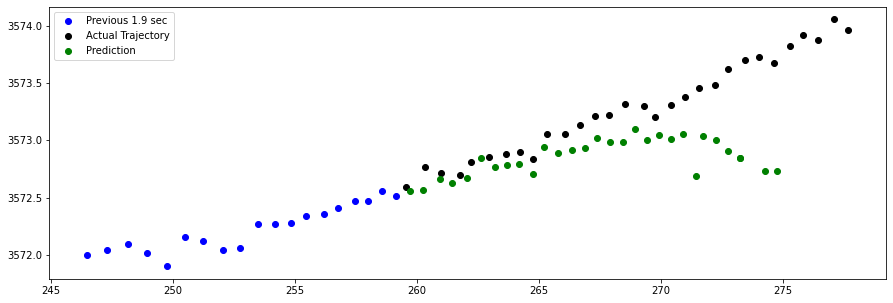

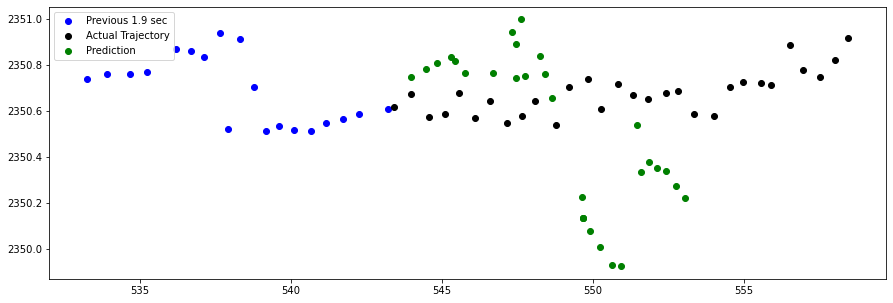

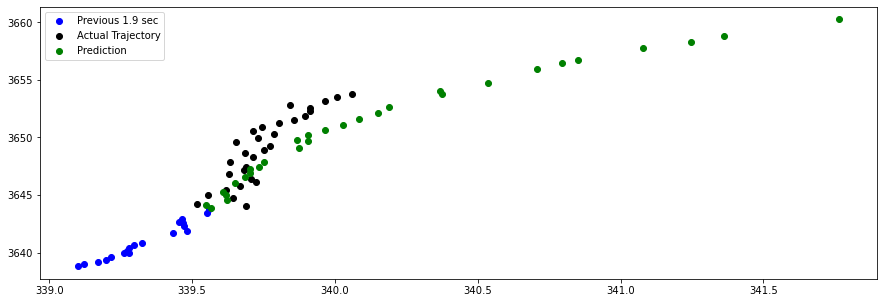

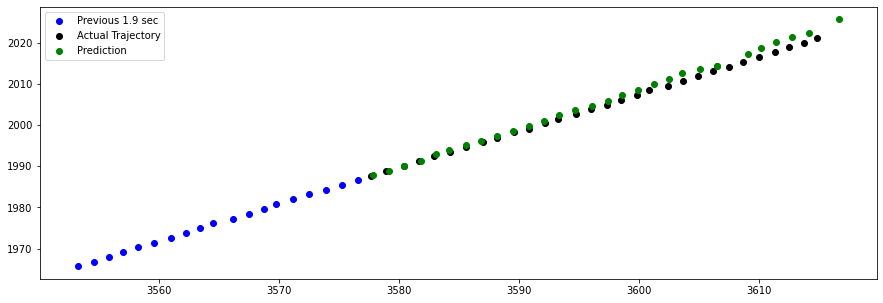

In [18]:
model.load_state_dict(torch.load('MLP-model.pt'))

samples, _ = torch.utils.data.random_split(TRAIN_SET, [10, 169660])

samples_loader = DataLoader(samples,batch_size=1, shuffle = False, 
                          collate_fn=my_collate, num_workers=4,pin_memory=True)

def show_sample_batch(sample, prediction, agent_id):
    """visualize the trajectory for a batch of samples with a randon agent"""
    inp, out = sample
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 5), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
#     axs = axs.ravel()   
#     for i in range(batch_sz):
#         axs[i].xaxis.set_ticks([])
#         axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        
    axs.scatter(inp[0, agent_id,:,0], inp[0, agent_id,:,1], color="blue")
    axs.scatter(pred_out[0, agent_id, :, 0], pred_out[0, agent_id, :, 1], color="black")
    axs.scatter(out[0, agent_id,:,0], out[0, agent_id,:,1], color="green")
    axs.legend(["Previous 1.9 sec", "Actual Trajectory", "Prediction"])

        
for i_batch, sample_batch in enumerate(samples_loader):
    
    model.eval()
    inp, out = sample_batch
    inp = inp.reshape(inp.shape[0], inp.shape[3] * inp.shape[1] * inp.shape[2])
    inp = inp.to(device)
    out = out.to(device)
    pred_out = model(inp)
    pred_out = pred_out.reshape(1, 60, 30, 2)
    pred_out = pred_out.cpu().data.numpy()
    
    track_id = samples[i_batch]['track_id']
    track_id = track_id[:,0,0]
    index = 0
    for i in range(len(track_id)):
        if samples[i_batch]['agent_id'] == track_id[i]:
            index = i
            break
    
    show_sample_batch(sample_batch, pred_out, index)

# Create CSV file

In [13]:
def collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp = [numpy.dstack([scene['p_in'], scene['v_in']]) for scene in batch]
    inp = torch.FloatTensor(inp)
    return inp

t_loader = DataLoader(test_dataset,batch_size=1, shuffle = False, collate_fn=collate, num_workers=0)

In [14]:
import csv

model.load_state_dict(torch.load('MLP-model.pt'))

header = ['ID']
for i in range(1, 61):
    header.append('v' + str(i))
    
with open('mlp.csv', 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile) 
        
    # writing the fields 
    csvwriter.writerow(header) 
        
    for i_batch, sample_batch in enumerate(t_loader):
        header = []
        header.append(test_dataset[i_batch]['scene_idx'])
        
        model.eval()
        inp = sample_batch
        inp = inp.reshape(inp.shape[0], inp.shape[3] * inp.shape[1] * inp.shape[2])
        inp = inp.to(device)
        pred_out = model(inp)
        pred_out = pred_out.reshape(1, 60, 30, 2)
        pred_out = pred_out.squeeze() 
        track_id = test_dataset[i_batch]['track_id']
        track_id = track_id[:,0,0]
        index = 0
        for i in range(len(track_id)):
            if test_dataset[i_batch]['agent_id'] == track_id[i]:
                index = i
                break
        p_out = pred_out[index]
        p_out = p_out.reshape(30*2)
        for i in range(len(p_out)):
            header.append(p_out[i].item())
            
        csvwriter.writerow(header)